# Neural Processes

Implementation of Neural Processes paper for Projects in Machine Learning and Artificial Intelligence course at TU Berlin

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rodrigobdz/neural-processes/blob/main/neural-processes.ipynb)

In [1]:
# Upload all .py files in neural_processes folder
# i.e. data_generator.py, decoder.py, encoder.py, mlp.py, model.py, and utils.py
from google.colab import files
uploaded = files.upload()

Saving data_generator.py to data_generator.py
Saving decoder.py to decoder.py
Saving encoder.py to encoder.py
Saving img_model.py to img_model.py
Saving __init__.py to __init__.py
Saving mlp.py to mlp.py
Saving mnist.py to mnist.py
Saving model.py to model.py
Saving plot.py to plot.py
Saving utils.py to utils.py


In [2]:
# Place uploaded files in neural_processes folder to mimic folder structure in repo
!rm -rf sample_data/
!mkdir -p neural_processes
!mv *.py neural_processes/

In [3]:
import neural_processes

In [4]:
import matplotlib.pyplot as plt

import torch
from torch import distributions
from torch import nn 
from torch import optim

import torchvision
from torchvision import datasets

In [5]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda')

In [ ]:
TRAINING_ITERATIONS = 100 #@param {type:"number"}
MAX_NUM_CONTEXT = 50 #@param {type:"number"}
PLOT_AFTER = 100 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}

random_kernel_parameters=True #@param {type:"boolean"}

batch_size = 16
max_num_context = MAX_NUM_CONTEXT
x_size = 1
y_size = 1
length_scale = 0.6
sigma_scale = 1.0
num_iter = TRAINING_ITERATIONS
save_iter = PLOT_AFTER

### Training Data

In [ ]:
gp = neural_processes.data_generator.GPCurves(batch_size, max_num_context, x_size, y_size, length_scale, sigma_scale, dev='cuda')
train_list = [gp.generate_curves() for _ in range(num_iter)]

### Output of 1D Gaussian Process data

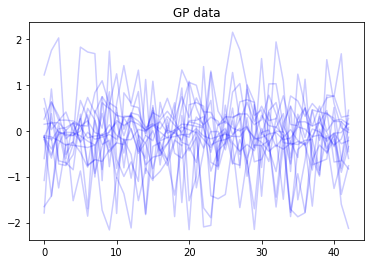

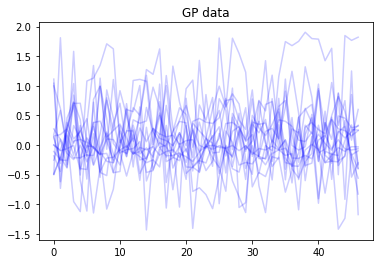

In [ ]:
for batch in train_list[:2]:
  _, _, xt, yt = batch 
  for x, y in zip(xt, yt):
    plt.plot(y.cpu(), c='b', alpha=.2)
    plt.title(label='GP data')
    
  plt.show()

### Test Data

In [ ]:
batch_size = 1
gptest = neural_processes.data_generator.GPCurves(batch_size, max_num_context, testing=True, dev='cuda')
test_list = [gptest.generate_curves() for _ in range(100)]

In [ ]:
in_features = 1 
h_size = HIDDEN_SIZE
encoder_out = [128, 256, 512, 1024] # [h_size]*4
decoder_out = [512, 256] + [2] # [128]*2 + [2] 

In [ ]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=128, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=128, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

In [ ]:
opt = optim.Adam(np.parameters(), lr=1e-4, eps=1e-07)

### Output of predictive distribution without training

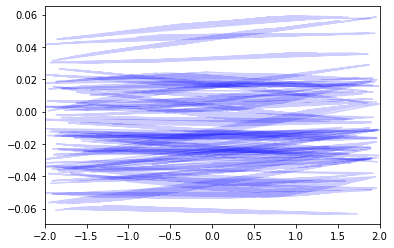

In [ ]:
for i in range(50):
  xc, yc, xt, yt = train_list[i]
  z = torch.rand((16, h_size)).to(dev)
  z = z[:, None, :].expand(-1, xt.shape[1], -1)
  mu, sig, distr = np._decoder(xt, z)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.xlim(-2, 2)

In [6]:
# Xavier_Uniform weight init
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
np.apply(init_weights)

# Training

Iteration: 0, loss: 1.1646907329559326


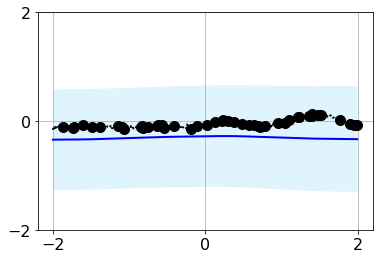

In [ ]:
mu, sigma, _ = np._fit(num_iter, save_iter, train_list, test_list, opt)

### Save Neural Process model to Google Drive
Uncomment the code in the following cell to enable this.

In [ ]:
# Mount drive
# Source: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
# from google.colab import drive
# drive.mount('/content/gdrive')

# Save model
# Source: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# !mkdir -p /content/gdrive/MyDrive/neural-processes-model
# torch.save(np, '/content/gdrive/MyDrive/neural-processes-model.pt')

In [ ]:
# Hotfix for missing HTTP headers in pytorch's HTTP request for MNIST dataset download
# Source:
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

### Output of predictive distribution after training given random latent Z (not related to stochastic process)


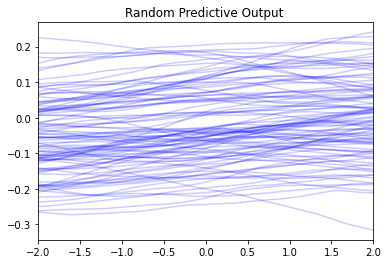

In [ ]:
for i in range(len(test_list)):
  xc, yc, xt, yt = test_list[i]
  z = torch.rand((1, h_size)).to(dev)
  z = z[:, None, :].expand(-1, xt.shape[1], -1)
  mu, sig, distr = np._decoder(xt, z)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.title(label='Random Predictive Output ')
  plt.xlim(-2, 2)

### Output of predictive distribution after training given sampled latent Z

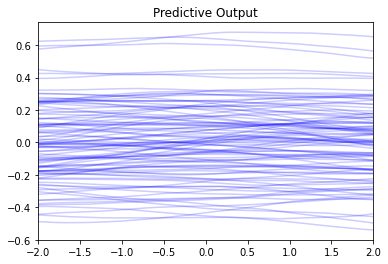

In [ ]:
for i in range(len(test_list)):
  xc, yc, xt, yt = test_list[i]
  # z = torch.rand((1, h_size))
  # z = z[:, None, :].expand(-1, xt.shape[1], -1)
  (mu, sig, distr), q = np(xc, yc, xt)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.title(label='Predictive Output')
  plt.xlim(-2, 2)

# Neural Processes for MNIST

In [7]:
# ToTensor() maps to range [0, 1]
train_mnist = datasets.MNIST('./data', download=True, transform=torchvision.transforms.ToTensor()) 
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

## Parameters

In [8]:
if dev.type == 'cuda':
  pin_memory = True
else:
  pin_memory = False

params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 0,
          'pin_memory': pin_memory}
          
train_generator = torch.utils.data.DataLoader(train_mnist, **params)

In [9]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0,
          'pin_memory': pin_memory}
          
test_generator = torch.utils.data.DataLoader(test_mnist, **params)

In [10]:
in_features = 2 
h_size = 256
encoder_out = [128] + [h_size]*3 # [128, 256, 512, 1024] 
decoder_out = [h_size]*2 + [2] # [512, 256] + [2] 

## Create model

In [11]:
np = neural_processes.img_model.ImgNeuralProcess(in_features, encoder_out, decoder_out, h_size)

np.apply(init_weights)

np.to(dev)

ImgNeuralProcess(
  (_np): NeuralProcess(
    (_encoder): Encoder(
      (_mlp): MLP(
        (linears): ModuleList(
          (0): Linear(in_features=3, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=256, bias=True)
          (5): ReLU()
          (6): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (_map): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (_mu): Linear(in_features=256, out_features=256, bias=True)
      (_log_sigma): Linear(in_features=256, out_features=256, bias=True)
    )
    (_decoder): Decoder(
      (_mlp): MLP(
        (linears): ModuleList(
          (0): Linear(in_features=258, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
         

In [12]:
# Define optimizer
opt = optim.Adam(np.parameters(), lr=5e-5, eps=1e-07)

## Fit NP model to MNIST dataset

Epoch: 0, Iteration: 0, loss: 0.8636564612388611
Epoch: 0, Iteration: 1000, loss: 0.3096901774406433
Epoch: 0, Iteration: 2000, loss: 0.0657578557729721
Epoch: 0, Iteration: 3000, loss: -0.05776766315102577
Iteration: 3749, loss: -0.12754970788955688


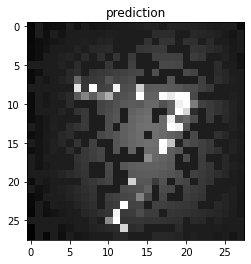

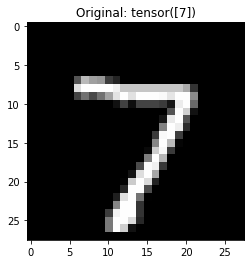

Epoch: 1, Iteration: 0, loss: -0.19342510402202606
Epoch: 1, Iteration: 1000, loss: -0.23818063735961914
Epoch: 1, Iteration: 2000, loss: -0.303964763879776
Epoch: 1, Iteration: 3000, loss: -0.3849209249019623
Epoch: 2, Iteration: 0, loss: -0.4791356027126312
Epoch: 2, Iteration: 1000, loss: -0.45500296354293823
Epoch: 2, Iteration: 2000, loss: -0.37702059745788574
Epoch: 2, Iteration: 3000, loss: -0.3441959619522095
Epoch: 3, Iteration: 0, loss: -0.4498497545719147
Epoch: 3, Iteration: 1000, loss: -0.4268112778663635
Epoch: 3, Iteration: 2000, loss: -0.5200394988059998
Epoch: 3, Iteration: 3000, loss: -0.36424559354782104
Epoch: 4, Iteration: 0, loss: -0.44149938225746155
Epoch: 4, Iteration: 1000, loss: -0.6234628558158875
Epoch: 4, Iteration: 2000, loss: -0.5376984477043152
Epoch: 4, Iteration: 3000, loss: -0.40742480754852295
Epoch: 5, Iteration: 0, loss: -0.4944908916950226
Epoch: 5, Iteration: 1000, loss: -0.5409873723983765
Epoch: 5, Iteration: 2000, loss: -0.4726777672767639
Ep

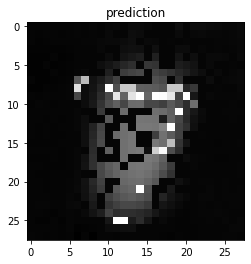

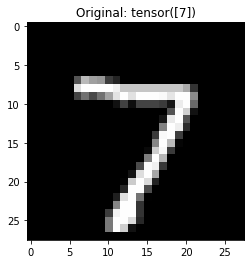

Epoch: 6, Iteration: 0, loss: -0.4526268541812897
Epoch: 6, Iteration: 1000, loss: -0.47616687417030334
Epoch: 6, Iteration: 2000, loss: -0.3081413507461548
Epoch: 6, Iteration: 3000, loss: -0.5895240306854248
Epoch: 7, Iteration: 0, loss: -0.5075470209121704
Epoch: 7, Iteration: 1000, loss: -0.4640752971172333
Epoch: 7, Iteration: 2000, loss: -0.42861324548721313
Epoch: 7, Iteration: 3000, loss: -0.5293907523155212
Epoch: 8, Iteration: 0, loss: -0.5408796668052673
Epoch: 8, Iteration: 1000, loss: -0.5405389666557312
Epoch: 8, Iteration: 2000, loss: -0.5395900011062622
Epoch: 8, Iteration: 3000, loss: -0.4809972047805786
Epoch: 9, Iteration: 0, loss: -0.5779848694801331
Epoch: 9, Iteration: 1000, loss: -0.5516929626464844
Epoch: 9, Iteration: 2000, loss: -0.5807421207427979
Epoch: 9, Iteration: 3000, loss: -0.553482174873352
Epoch: 10, Iteration: 0, loss: -0.5895606279373169
Epoch: 10, Iteration: 1000, loss: -0.5875925421714783
Epoch: 10, Iteration: 2000, loss: -0.6272856593132019
Epoc

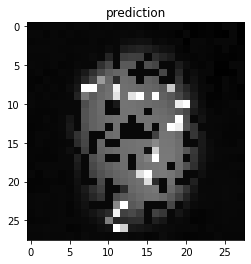

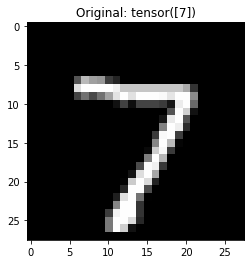

Epoch: 11, Iteration: 0, loss: -0.595389723777771
Epoch: 11, Iteration: 1000, loss: -0.6565114259719849
Epoch: 11, Iteration: 2000, loss: -0.5900341868400574
Epoch: 11, Iteration: 3000, loss: -0.6673637628555298
Epoch: 12, Iteration: 0, loss: -0.6772009134292603
Epoch: 12, Iteration: 1000, loss: -0.4159260094165802
Epoch: 12, Iteration: 2000, loss: -0.5336006283760071
Epoch: 12, Iteration: 3000, loss: -0.6113320589065552
Epoch: 13, Iteration: 0, loss: -0.5708184838294983
Epoch: 13, Iteration: 1000, loss: -0.6679298877716064
Epoch: 13, Iteration: 2000, loss: -0.6518793702125549
Epoch: 13, Iteration: 3000, loss: -0.5819156169891357
Epoch: 14, Iteration: 0, loss: -0.6350910663604736
Epoch: 14, Iteration: 1000, loss: -0.6544061303138733
Epoch: 14, Iteration: 2000, loss: -0.6405695080757141
Epoch: 14, Iteration: 3000, loss: -0.6409695148468018
Epoch: 15, Iteration: 0, loss: -0.58684241771698
Epoch: 15, Iteration: 1000, loss: -0.6522582173347473
Epoch: 15, Iteration: 2000, loss: -0.658070683

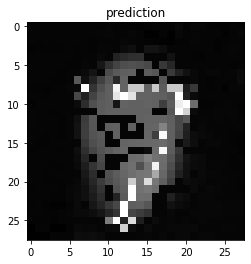

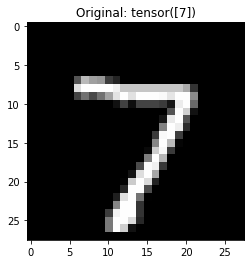

Epoch: 16, Iteration: 0, loss: -0.7054936289787292
Epoch: 16, Iteration: 1000, loss: -0.659780740737915
Epoch: 16, Iteration: 2000, loss: -0.7238509058952332
Epoch: 16, Iteration: 3000, loss: -0.5690696239471436
Epoch: 17, Iteration: 0, loss: -0.5518056750297546
Epoch: 17, Iteration: 1000, loss: -0.5676283240318298
Epoch: 17, Iteration: 2000, loss: -0.6730996966362
Epoch: 17, Iteration: 3000, loss: -0.5538308620452881
Epoch: 18, Iteration: 0, loss: -0.5558186173439026
Epoch: 18, Iteration: 1000, loss: -0.661695659160614
Epoch: 18, Iteration: 2000, loss: -0.5626728534698486
Epoch: 18, Iteration: 3000, loss: -0.5590140223503113
Epoch: 19, Iteration: 0, loss: -0.6729932427406311
Epoch: 19, Iteration: 1000, loss: -0.6240611672401428
Epoch: 19, Iteration: 2000, loss: -0.6651583313941956
Epoch: 19, Iteration: 3000, loss: -0.6748847961425781
Epoch: 20, Iteration: 0, loss: -0.6442667841911316
Epoch: 20, Iteration: 1000, loss: -0.6158906817436218
Epoch: 20, Iteration: 2000, loss: -0.68160319328

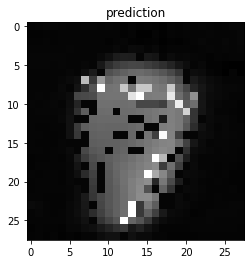

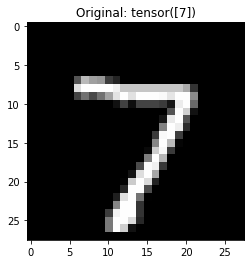

Epoch: 21, Iteration: 0, loss: -0.6879106163978577
Epoch: 21, Iteration: 1000, loss: -0.6473981738090515
Epoch: 21, Iteration: 2000, loss: -0.7000331282615662
Epoch: 21, Iteration: 3000, loss: -0.6720995306968689
Epoch: 22, Iteration: 0, loss: -0.6832667589187622
Epoch: 22, Iteration: 1000, loss: -0.6180179715156555
Epoch: 22, Iteration: 2000, loss: -0.7094358801841736
Epoch: 22, Iteration: 3000, loss: -0.6280220746994019
Epoch: 23, Iteration: 0, loss: -0.34577804803848267
Epoch: 23, Iteration: 1000, loss: -0.7251967191696167
Epoch: 23, Iteration: 2000, loss: -0.7214499711990356
Epoch: 23, Iteration: 3000, loss: -0.7108451724052429
Epoch: 24, Iteration: 0, loss: -0.6560088396072388
Epoch: 24, Iteration: 1000, loss: -0.7439401149749756
Epoch: 24, Iteration: 2000, loss: -0.7804594039916992
Epoch: 24, Iteration: 3000, loss: -0.7230767607688904
Epoch: 25, Iteration: 0, loss: -0.6796619892120361
Epoch: 25, Iteration: 1000, loss: -0.6952345371246338
Epoch: 25, Iteration: 2000, loss: -0.68042

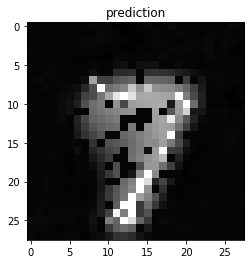

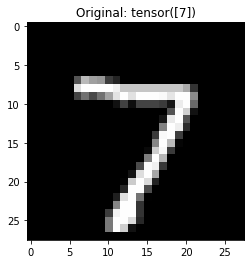

Epoch: 26, Iteration: 0, loss: -0.7543699741363525
Epoch: 26, Iteration: 1000, loss: -0.8244218826293945
Epoch: 26, Iteration: 2000, loss: 0.14825545251369476
Epoch: 26, Iteration: 3000, loss: -0.64021897315979
Epoch: 27, Iteration: 0, loss: -0.7419766187667847
Epoch: 27, Iteration: 1000, loss: -0.6848673820495605
Epoch: 27, Iteration: 2000, loss: -0.7514986991882324
Epoch: 27, Iteration: 3000, loss: -0.6432019472122192
Epoch: 28, Iteration: 0, loss: -0.7407422065734863
Epoch: 28, Iteration: 1000, loss: -0.6966688632965088
Epoch: 28, Iteration: 2000, loss: -0.777633786201477
Epoch: 28, Iteration: 3000, loss: -0.7174077033996582
Epoch: 29, Iteration: 0, loss: -0.7440215945243835
Epoch: 29, Iteration: 1000, loss: -0.7394164800643921
Epoch: 29, Iteration: 2000, loss: -0.7638314366340637
Epoch: 29, Iteration: 3000, loss: -0.7417625784873962
Epoch: 30, Iteration: 0, loss: -0.651518702507019
Epoch: 30, Iteration: 1000, loss: -0.8175223469734192
Epoch: 30, Iteration: 2000, loss: -0.7042870521

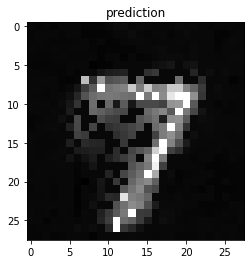

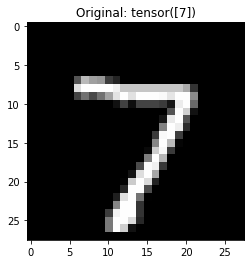

Epoch: 31, Iteration: 0, loss: -0.8355194330215454
Epoch: 31, Iteration: 1000, loss: -0.6663479208946228
Epoch: 31, Iteration: 2000, loss: -0.5963835716247559
Epoch: 31, Iteration: 3000, loss: -0.6967546343803406
Epoch: 32, Iteration: 0, loss: -0.7170679569244385
Epoch: 32, Iteration: 1000, loss: -0.7255422472953796
Epoch: 32, Iteration: 2000, loss: -0.6900866031646729
Epoch: 32, Iteration: 3000, loss: -0.7282012701034546
Epoch: 33, Iteration: 0, loss: -0.7819639444351196
Epoch: 33, Iteration: 1000, loss: -0.7543027997016907
Epoch: 33, Iteration: 2000, loss: -0.6853125095367432
Epoch: 33, Iteration: 3000, loss: -0.7432913184165955
Epoch: 34, Iteration: 0, loss: -0.7331405878067017
Epoch: 34, Iteration: 1000, loss: -0.7490220069885254
Epoch: 34, Iteration: 2000, loss: -0.7149999737739563
Epoch: 34, Iteration: 3000, loss: -0.7606775164604187
Epoch: 35, Iteration: 0, loss: -0.8332919478416443
Epoch: 35, Iteration: 1000, loss: -0.7783575654029846
Epoch: 35, Iteration: 2000, loss: -0.832520

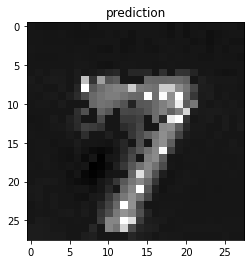

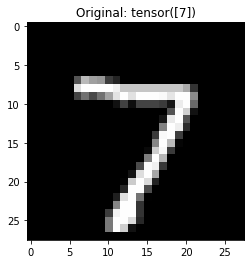

Epoch: 36, Iteration: 0, loss: -0.6784905791282654
Epoch: 36, Iteration: 1000, loss: -0.7147912383079529
Epoch: 36, Iteration: 2000, loss: -0.810088038444519
Epoch: 36, Iteration: 3000, loss: -0.7201435565948486
Epoch: 37, Iteration: 0, loss: -0.7673595547676086
Epoch: 37, Iteration: 1000, loss: -0.7474313974380493
Epoch: 37, Iteration: 2000, loss: -0.6879092454910278
Epoch: 37, Iteration: 3000, loss: -0.6893357634544373
Epoch: 38, Iteration: 0, loss: -0.8317251801490784
Epoch: 38, Iteration: 1000, loss: -0.7412301301956177
Epoch: 38, Iteration: 2000, loss: -0.7029343247413635
Epoch: 38, Iteration: 3000, loss: -0.7926074862480164
Epoch: 39, Iteration: 0, loss: -0.7304344177246094
Epoch: 39, Iteration: 1000, loss: -0.7426953911781311
Epoch: 39, Iteration: 2000, loss: -0.7954206466674805
Epoch: 39, Iteration: 3000, loss: -0.7939419746398926
Epoch: 40, Iteration: 0, loss: -0.8051692247390747
Epoch: 40, Iteration: 1000, loss: -0.7622930407524109
Epoch: 40, Iteration: 2000, loss: -0.8729838

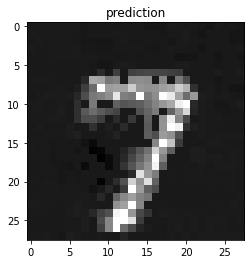

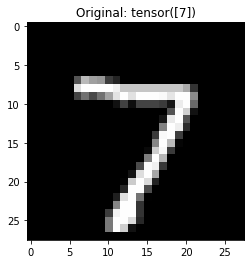

Epoch: 41, Iteration: 0, loss: -0.7371045351028442
Epoch: 41, Iteration: 1000, loss: -0.7994564771652222
Epoch: 41, Iteration: 2000, loss: -0.7141098380088806
Epoch: 41, Iteration: 3000, loss: -0.7877717018127441
Epoch: 42, Iteration: 0, loss: -0.8089495897293091
Epoch: 42, Iteration: 1000, loss: -0.617675244808197
Epoch: 42, Iteration: 2000, loss: -0.8474984765052795
Epoch: 42, Iteration: 3000, loss: -0.8003244996070862
Epoch: 43, Iteration: 0, loss: -0.7723126411437988
Epoch: 43, Iteration: 1000, loss: -0.7653332352638245
Epoch: 43, Iteration: 2000, loss: -0.7498478889465332
Epoch: 43, Iteration: 3000, loss: -0.7561505436897278
Epoch: 44, Iteration: 0, loss: -0.7298548817634583
Epoch: 44, Iteration: 1000, loss: -0.7514804601669312
Epoch: 44, Iteration: 2000, loss: -0.707545816898346
Epoch: 44, Iteration: 3000, loss: -0.7333587408065796
Epoch: 45, Iteration: 0, loss: -0.662706732749939
Epoch: 45, Iteration: 1000, loss: -0.49717533588409424
Epoch: 45, Iteration: 2000, loss: -0.76770943

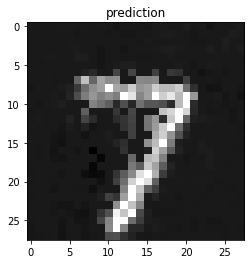

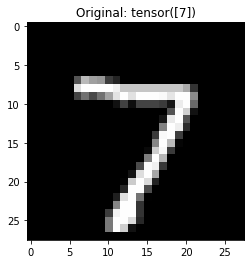

Epoch: 46, Iteration: 0, loss: -0.8073424100875854
Epoch: 46, Iteration: 1000, loss: -0.754135012626648
Epoch: 46, Iteration: 2000, loss: -0.6538238525390625
Epoch: 46, Iteration: 3000, loss: -0.7754651308059692
Epoch: 47, Iteration: 0, loss: -0.750847339630127
Epoch: 47, Iteration: 1000, loss: -0.7125752568244934
Epoch: 47, Iteration: 2000, loss: -0.7542970180511475
Epoch: 47, Iteration: 3000, loss: -0.7606902718544006
Epoch: 48, Iteration: 0, loss: -0.635273814201355
Epoch: 48, Iteration: 1000, loss: -0.8149527311325073
Epoch: 48, Iteration: 2000, loss: -0.7729809284210205
Epoch: 48, Iteration: 3000, loss: -0.7696919441223145
Epoch: 49, Iteration: 0, loss: -0.7316856980323792
Epoch: 49, Iteration: 1000, loss: -0.8145264983177185
Epoch: 49, Iteration: 2000, loss: -0.7712355256080627
Epoch: 49, Iteration: 3000, loss: -0.7720711827278137
Epoch: 50, Iteration: 0, loss: -0.8686920404434204
Epoch: 50, Iteration: 1000, loss: -0.8057080507278442
Epoch: 50, Iteration: 2000, loss: -0.760027527

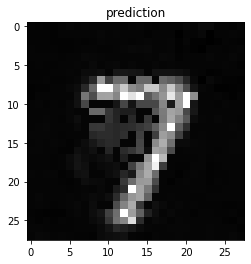

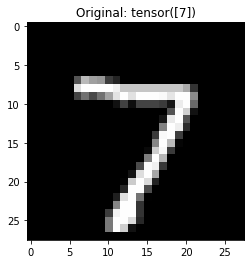

Epoch: 51, Iteration: 0, loss: -0.8502153158187866
Epoch: 51, Iteration: 1000, loss: -0.7966240644454956
Epoch: 51, Iteration: 2000, loss: -0.749988853931427
Epoch: 51, Iteration: 3000, loss: -0.8543294668197632
Epoch: 52, Iteration: 0, loss: -0.806605875492096
Epoch: 52, Iteration: 1000, loss: -0.8596723675727844
Epoch: 52, Iteration: 2000, loss: -0.7959105372428894
Epoch: 52, Iteration: 3000, loss: -0.707223117351532
Epoch: 53, Iteration: 0, loss: -0.8459097743034363
Epoch: 53, Iteration: 1000, loss: -0.7021851539611816
Epoch: 53, Iteration: 2000, loss: -0.7405297756195068
Epoch: 53, Iteration: 3000, loss: -0.8546000719070435
Epoch: 54, Iteration: 0, loss: -0.7837149500846863
Epoch: 54, Iteration: 1000, loss: -0.7503030300140381
Epoch: 54, Iteration: 2000, loss: -0.786433219909668
Epoch: 54, Iteration: 3000, loss: -0.8706172108650208
Epoch: 55, Iteration: 0, loss: -0.8507617712020874
Epoch: 55, Iteration: 1000, loss: -0.7996253967285156
Epoch: 55, Iteration: 2000, loss: -0.7847186326

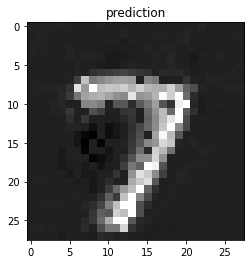

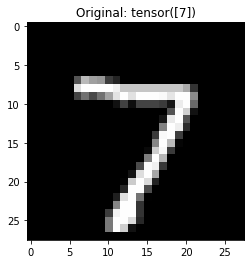

Epoch: 56, Iteration: 0, loss: -0.6803745031356812
Epoch: 56, Iteration: 1000, loss: -0.7789298295974731
Epoch: 56, Iteration: 2000, loss: -0.611956775188446
Epoch: 56, Iteration: 3000, loss: -0.8129754662513733
Epoch: 57, Iteration: 0, loss: -0.8047612905502319
Epoch: 57, Iteration: 1000, loss: -0.6304111480712891
Epoch: 57, Iteration: 2000, loss: -0.7996677756309509
Epoch: 57, Iteration: 3000, loss: -0.8556971549987793
Epoch: 58, Iteration: 0, loss: -0.7284279465675354
Epoch: 58, Iteration: 1000, loss: -0.8074608445167542
Epoch: 58, Iteration: 2000, loss: -0.8700793385505676
Epoch: 58, Iteration: 3000, loss: -0.7999508380889893
Epoch: 59, Iteration: 0, loss: -0.7822559475898743
Epoch: 59, Iteration: 1000, loss: -0.7776872515678406
Epoch: 59, Iteration: 2000, loss: -0.8129073977470398
Epoch: 59, Iteration: 3000, loss: -0.8468020558357239
Epoch: 60, Iteration: 0, loss: -0.5398811101913452
Epoch: 60, Iteration: 1000, loss: -0.7980504035949707
Epoch: 60, Iteration: 2000, loss: -0.7665247

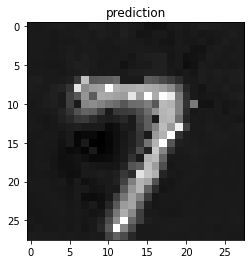

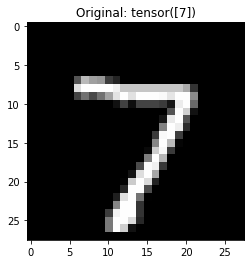

Epoch: 61, Iteration: 0, loss: -0.7418472766876221
Epoch: 61, Iteration: 1000, loss: -0.8767525553703308
Epoch: 61, Iteration: 2000, loss: -0.8187122344970703
Epoch: 61, Iteration: 3000, loss: -0.7734239101409912
Epoch: 62, Iteration: 0, loss: -0.759556770324707
Epoch: 62, Iteration: 1000, loss: -0.9164531230926514
Epoch: 62, Iteration: 2000, loss: -0.7268320322036743
Epoch: 62, Iteration: 3000, loss: -0.7573361396789551
Epoch: 63, Iteration: 0, loss: -0.7095304727554321
Epoch: 63, Iteration: 1000, loss: -0.7524710297584534
Epoch: 63, Iteration: 2000, loss: -0.7333539128303528
Epoch: 63, Iteration: 3000, loss: -0.6880408525466919
Epoch: 64, Iteration: 0, loss: -0.7528170347213745
Epoch: 64, Iteration: 1000, loss: -0.6686422228813171
Epoch: 64, Iteration: 2000, loss: -0.8141465783119202
Epoch: 64, Iteration: 3000, loss: -0.7389022707939148
Epoch: 65, Iteration: 0, loss: -0.8110455274581909
Epoch: 65, Iteration: 1000, loss: -0.8153328895568848
Epoch: 65, Iteration: 2000, loss: -0.7969073

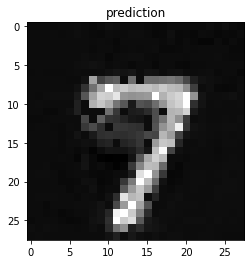

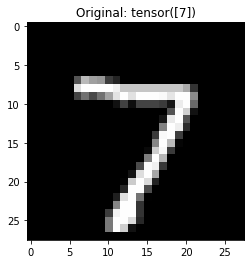

Epoch: 66, Iteration: 0, loss: -0.8394320011138916
Epoch: 66, Iteration: 1000, loss: -0.8387787342071533
Epoch: 66, Iteration: 2000, loss: -0.8335686326026917
Epoch: 66, Iteration: 3000, loss: -0.4794999659061432
Epoch: 67, Iteration: 0, loss: -0.9189106225967407
Epoch: 67, Iteration: 1000, loss: -0.7616873383522034
Epoch: 67, Iteration: 2000, loss: -0.8310146331787109
Epoch: 67, Iteration: 3000, loss: -0.6727843284606934
Epoch: 68, Iteration: 0, loss: -0.7099147439002991
Epoch: 68, Iteration: 1000, loss: -0.863463282585144
Epoch: 68, Iteration: 2000, loss: -0.8474714159965515
Epoch: 68, Iteration: 3000, loss: -0.7412087917327881
Epoch: 69, Iteration: 0, loss: -0.8228595852851868
Epoch: 69, Iteration: 1000, loss: -0.8229159712791443
Epoch: 69, Iteration: 2000, loss: -0.6892973184585571
Epoch: 69, Iteration: 3000, loss: -0.8148574233055115
Epoch: 70, Iteration: 0, loss: -0.8092654347419739
Epoch: 70, Iteration: 1000, loss: -0.8146936893463135
Epoch: 70, Iteration: 2000, loss: -0.8750013

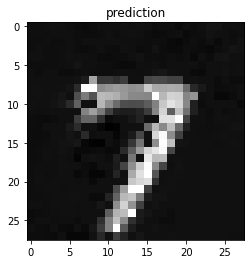

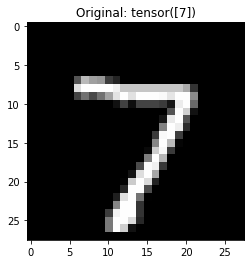

Epoch: 71, Iteration: 0, loss: -0.84203040599823
Epoch: 71, Iteration: 1000, loss: -0.8571937680244446
Epoch: 71, Iteration: 2000, loss: -0.8283557295799255
Epoch: 71, Iteration: 3000, loss: -0.7116257548332214
Epoch: 72, Iteration: 0, loss: -0.7405350208282471
Epoch: 72, Iteration: 1000, loss: -0.7891704440116882
Epoch: 72, Iteration: 2000, loss: -0.8990157246589661
Epoch: 72, Iteration: 3000, loss: -0.8025895357131958
Epoch: 73, Iteration: 0, loss: -0.6697989106178284
Epoch: 73, Iteration: 1000, loss: -0.7990023493766785
Epoch: 73, Iteration: 2000, loss: -0.7928516864776611
Epoch: 73, Iteration: 3000, loss: -0.7834081053733826
Epoch: 74, Iteration: 0, loss: -0.8458226919174194
Epoch: 74, Iteration: 1000, loss: -0.4740414023399353
Epoch: 74, Iteration: 2000, loss: -0.9882620573043823
Epoch: 74, Iteration: 3000, loss: -0.8475533127784729
Epoch: 75, Iteration: 0, loss: -0.8661131858825684
Epoch: 75, Iteration: 1000, loss: -0.8314966559410095
Epoch: 75, Iteration: 2000, loss: -0.76411736

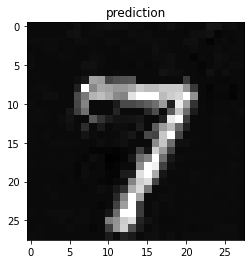

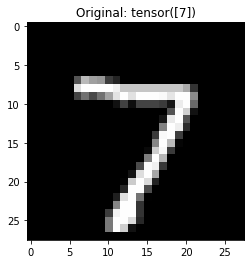

Epoch: 76, Iteration: 0, loss: -0.8056866526603699
Epoch: 76, Iteration: 1000, loss: -0.8929369449615479
Epoch: 76, Iteration: 2000, loss: -0.8701061010360718
Epoch: 76, Iteration: 3000, loss: -0.8825205564498901
Epoch: 77, Iteration: 0, loss: -0.8512988090515137
Epoch: 77, Iteration: 1000, loss: -0.7092623710632324
Epoch: 77, Iteration: 2000, loss: -0.8833214640617371
Epoch: 77, Iteration: 3000, loss: -0.8231806755065918
Epoch: 78, Iteration: 0, loss: -0.6599507331848145
Epoch: 78, Iteration: 1000, loss: -0.8002467751502991
Epoch: 78, Iteration: 2000, loss: -0.8266441822052002
Epoch: 78, Iteration: 3000, loss: -0.8509109616279602
Epoch: 79, Iteration: 0, loss: -0.8965279459953308
Epoch: 79, Iteration: 1000, loss: -0.8754562735557556
Epoch: 79, Iteration: 2000, loss: -0.7654219269752502
Epoch: 79, Iteration: 3000, loss: -0.7852059006690979
Epoch: 80, Iteration: 0, loss: -0.7874014973640442
Epoch: 80, Iteration: 1000, loss: -0.7962015867233276
Epoch: 80, Iteration: 2000, loss: -0.758928

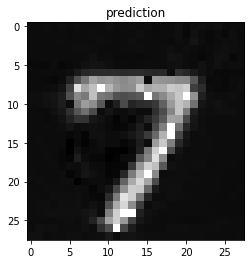

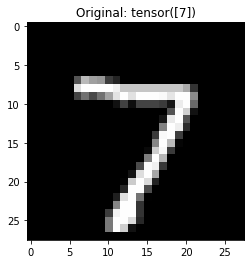

Epoch: 81, Iteration: 0, loss: -0.7888116240501404
Epoch: 81, Iteration: 1000, loss: -0.8374707102775574
Epoch: 81, Iteration: 2000, loss: -0.8117915391921997
Epoch: 81, Iteration: 3000, loss: -0.7927483320236206
Epoch: 82, Iteration: 0, loss: -0.8178426623344421
Epoch: 82, Iteration: 1000, loss: -0.8240200281143188
Epoch: 82, Iteration: 2000, loss: -0.8617647290229797
Epoch: 82, Iteration: 3000, loss: -0.9061456918716431
Epoch: 83, Iteration: 0, loss: -0.21129319071769714
Epoch: 83, Iteration: 1000, loss: -0.8531225919723511
Epoch: 83, Iteration: 2000, loss: -0.6501774787902832
Epoch: 83, Iteration: 3000, loss: -0.8639848232269287
Epoch: 84, Iteration: 0, loss: -0.8734755516052246
Epoch: 84, Iteration: 1000, loss: -0.8135482668876648
Epoch: 84, Iteration: 2000, loss: -0.7957106232643127
Epoch: 84, Iteration: 3000, loss: -0.8220574855804443
Epoch: 85, Iteration: 0, loss: -0.8200371861457825
Epoch: 85, Iteration: 1000, loss: -0.8483675718307495
Epoch: 85, Iteration: 2000, loss: -0.87159

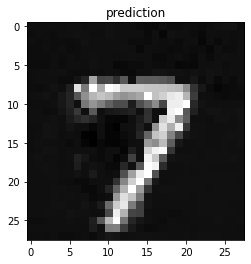

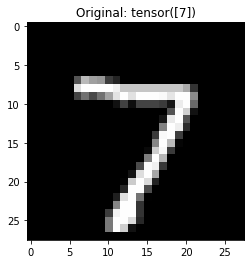

Epoch: 86, Iteration: 0, loss: -0.8133161067962646
Epoch: 86, Iteration: 1000, loss: -0.8588088750839233
Epoch: 86, Iteration: 2000, loss: -0.7735996246337891
Epoch: 86, Iteration: 3000, loss: -0.8246769309043884
Epoch: 87, Iteration: 0, loss: -0.8295226097106934
Epoch: 87, Iteration: 1000, loss: -0.8627474904060364
Epoch: 87, Iteration: 2000, loss: -0.9278088808059692
Epoch: 87, Iteration: 3000, loss: -0.757192075252533
Epoch: 88, Iteration: 0, loss: -0.8471653461456299
Epoch: 88, Iteration: 1000, loss: -0.8745374083518982
Epoch: 88, Iteration: 2000, loss: -0.8549955487251282
Epoch: 88, Iteration: 3000, loss: -0.8645278811454773
Epoch: 89, Iteration: 0, loss: -0.9667065143585205
Epoch: 89, Iteration: 1000, loss: -0.7372250556945801
Epoch: 89, Iteration: 2000, loss: -0.8950415253639221
Epoch: 89, Iteration: 3000, loss: -0.7876883745193481
Epoch: 90, Iteration: 0, loss: -0.9086638689041138
Epoch: 90, Iteration: 1000, loss: -0.8894096612930298
Epoch: 90, Iteration: 2000, loss: -0.8930829

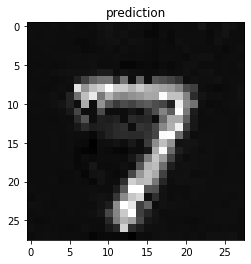

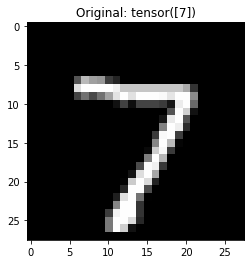

Epoch: 91, Iteration: 0, loss: -0.8587022423744202
Epoch: 91, Iteration: 1000, loss: -0.2667456567287445
Epoch: 91, Iteration: 2000, loss: -0.8601070046424866
Epoch: 91, Iteration: 3000, loss: -0.9634087085723877
Epoch: 92, Iteration: 0, loss: -0.9467183351516724
Epoch: 92, Iteration: 1000, loss: -0.8838316798210144
Epoch: 92, Iteration: 2000, loss: -0.9303980469703674
Epoch: 92, Iteration: 3000, loss: -0.8367158770561218
Epoch: 93, Iteration: 0, loss: -0.8923087120056152
Epoch: 93, Iteration: 1000, loss: -0.8258775472640991
Epoch: 93, Iteration: 2000, loss: -0.8081538081169128
Epoch: 93, Iteration: 3000, loss: -0.8678202629089355
Epoch: 94, Iteration: 0, loss: -0.83332359790802
Epoch: 94, Iteration: 1000, loss: -0.9005429744720459
Epoch: 94, Iteration: 2000, loss: -0.8919274806976318
Epoch: 94, Iteration: 3000, loss: -0.7893185615539551
Epoch: 95, Iteration: 0, loss: -0.787500262260437
Epoch: 95, Iteration: 1000, loss: -0.8764626979827881
Epoch: 95, Iteration: 2000, loss: -0.929455995

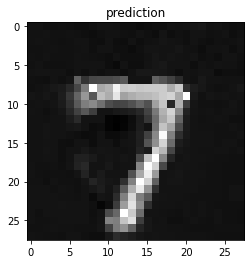

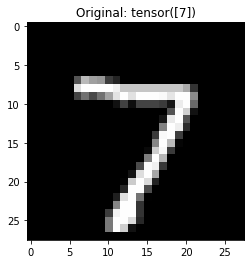

Epoch: 96, Iteration: 0, loss: -0.6241366863250732
Epoch: 96, Iteration: 1000, loss: -0.7760208249092102
Epoch: 96, Iteration: 2000, loss: -0.832640528678894
Epoch: 96, Iteration: 3000, loss: -0.9188482761383057
Epoch: 97, Iteration: 0, loss: -0.614022433757782
Epoch: 97, Iteration: 1000, loss: -0.8917937874794006
Epoch: 97, Iteration: 2000, loss: -0.7316286563873291
Epoch: 97, Iteration: 3000, loss: -0.262121319770813
Epoch: 98, Iteration: 0, loss: -0.9071363806724548
Epoch: 98, Iteration: 1000, loss: -0.9507059454917908
Epoch: 98, Iteration: 2000, loss: -0.9172429442405701
Epoch: 98, Iteration: 3000, loss: -0.8987265229225159
Epoch: 99, Iteration: 0, loss: -0.9370200037956238
Epoch: 99, Iteration: 1000, loss: -0.7658639550209045
Epoch: 99, Iteration: 2000, loss: -0.8892497420310974
Epoch: 99, Iteration: 3000, loss: -0.8433184623718262
Epoch: 100, Iteration: 0, loss: -0.8620830178260803
Epoch: 100, Iteration: 1000, loss: -0.8949124813079834
Epoch: 100, Iteration: 2000, loss: -0.796486

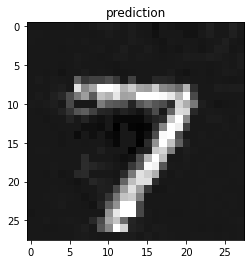

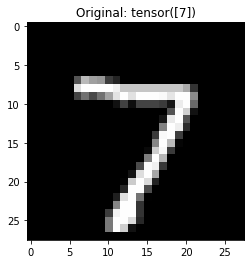

Epoch: 101, Iteration: 0, loss: -0.9185301065444946
Epoch: 101, Iteration: 1000, loss: -0.8737697601318359
Epoch: 101, Iteration: 2000, loss: -0.9045164585113525
Epoch: 101, Iteration: 3000, loss: -0.7222583889961243
Epoch: 102, Iteration: 0, loss: -0.9487413167953491
Epoch: 102, Iteration: 1000, loss: -0.872641384601593
Epoch: 102, Iteration: 2000, loss: -0.8816133737564087
Epoch: 102, Iteration: 3000, loss: -0.7678824067115784
Epoch: 103, Iteration: 0, loss: -0.862575113773346
Epoch: 103, Iteration: 1000, loss: -0.8704888820648193
Epoch: 103, Iteration: 2000, loss: -0.7642707824707031
Epoch: 103, Iteration: 3000, loss: -0.8589772582054138
Epoch: 104, Iteration: 0, loss: -0.8530314564704895
Epoch: 104, Iteration: 1000, loss: -0.751172661781311
Epoch: 104, Iteration: 2000, loss: -0.8695892691612244
Epoch: 104, Iteration: 3000, loss: -0.8569990992546082
Epoch: 105, Iteration: 0, loss: -0.8862708210945129
Epoch: 105, Iteration: 1000, loss: -0.8941453099250793
Epoch: 105, Iteration: 2000,

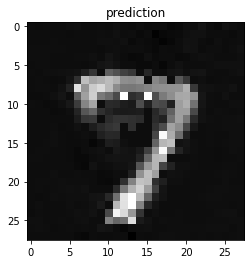

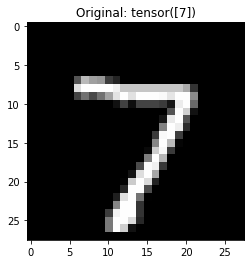

Epoch: 106, Iteration: 0, loss: -0.9154051542282104
Epoch: 106, Iteration: 1000, loss: -0.9538255929946899
Epoch: 106, Iteration: 2000, loss: -0.8649516105651855
Epoch: 106, Iteration: 3000, loss: -0.6581039428710938
Epoch: 107, Iteration: 0, loss: -0.8787303566932678
Epoch: 107, Iteration: 1000, loss: -0.8865756392478943
Epoch: 107, Iteration: 2000, loss: -0.8942423462867737
Epoch: 107, Iteration: 3000, loss: -0.034225352108478546
Epoch: 108, Iteration: 0, loss: -0.32744795083999634
Epoch: 108, Iteration: 1000, loss: -0.9265602827072144
Epoch: 108, Iteration: 2000, loss: -0.8820575475692749
Epoch: 108, Iteration: 3000, loss: -0.93841552734375
Epoch: 109, Iteration: 0, loss: -0.3458510637283325
Epoch: 109, Iteration: 1000, loss: -0.8508915901184082
Epoch: 109, Iteration: 2000, loss: -0.7584145665168762
Epoch: 109, Iteration: 3000, loss: -0.6728209257125854
Epoch: 110, Iteration: 0, loss: -0.8352356553077698
Epoch: 110, Iteration: 1000, loss: -0.8898105025291443
Epoch: 110, Iteration: 2

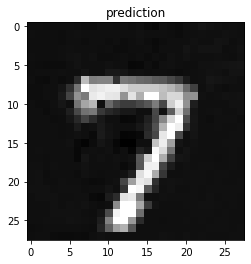

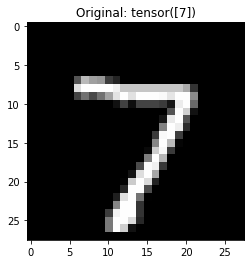

Epoch: 111, Iteration: 0, loss: -0.9440762996673584
Epoch: 111, Iteration: 1000, loss: -0.8886785507202148
Epoch: 111, Iteration: 2000, loss: -0.6470090746879578
Epoch: 111, Iteration: 3000, loss: -0.8919227719306946
Epoch: 112, Iteration: 0, loss: -0.9189472794532776
Epoch: 112, Iteration: 1000, loss: -0.9266519546508789
Epoch: 112, Iteration: 2000, loss: -0.822464644908905
Epoch: 112, Iteration: 3000, loss: -0.9290082454681396
Epoch: 113, Iteration: 0, loss: -0.9342979788780212
Epoch: 113, Iteration: 1000, loss: -0.8971717357635498
Epoch: 113, Iteration: 2000, loss: -0.8891103863716125
Epoch: 113, Iteration: 3000, loss: -0.8027058243751526
Epoch: 114, Iteration: 0, loss: -0.8565691709518433
Epoch: 114, Iteration: 1000, loss: -0.9411090612411499
Epoch: 114, Iteration: 2000, loss: -0.8262567520141602
Epoch: 114, Iteration: 3000, loss: -0.9282330274581909
Epoch: 115, Iteration: 0, loss: -0.8561310172080994
Epoch: 115, Iteration: 1000, loss: -0.8465071320533752
Epoch: 115, Iteration: 200

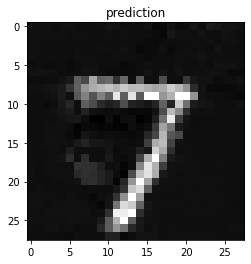

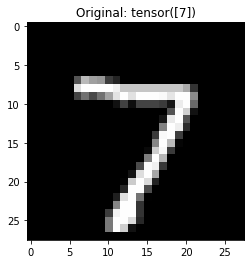

Epoch: 116, Iteration: 0, loss: -0.8406093120574951
Epoch: 116, Iteration: 1000, loss: -0.9609223008155823
Epoch: 116, Iteration: 2000, loss: -0.9156255722045898
Epoch: 116, Iteration: 3000, loss: -0.8814864754676819
Epoch: 117, Iteration: 0, loss: -0.8765913844108582
Epoch: 117, Iteration: 1000, loss: -0.8322615027427673
Epoch: 117, Iteration: 2000, loss: -0.8794685006141663
Epoch: 117, Iteration: 3000, loss: -0.7961487770080566
Epoch: 118, Iteration: 0, loss: -0.8676620125770569
Epoch: 118, Iteration: 1000, loss: -0.7762344479560852
Epoch: 118, Iteration: 2000, loss: -0.8651619553565979
Epoch: 118, Iteration: 3000, loss: -0.9020273685455322
Epoch: 119, Iteration: 0, loss: -0.8993912935256958
Epoch: 119, Iteration: 1000, loss: -0.9700027704238892
Epoch: 119, Iteration: 2000, loss: -0.8821425437927246
Epoch: 119, Iteration: 3000, loss: -0.8482105135917664
Epoch: 120, Iteration: 0, loss: -0.8269366025924683
Epoch: 120, Iteration: 1000, loss: -0.9021868109703064
Epoch: 120, Iteration: 20

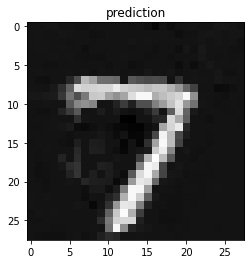

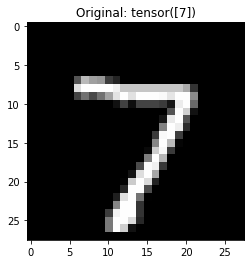

Epoch: 121, Iteration: 0, loss: -0.8591599464416504
Epoch: 121, Iteration: 1000, loss: -0.9019654393196106
Epoch: 121, Iteration: 2000, loss: -0.9360622763633728
Epoch: 121, Iteration: 3000, loss: -0.9115976095199585
Epoch: 122, Iteration: 0, loss: -0.8026124238967896
Epoch: 122, Iteration: 1000, loss: -0.9728226661682129
Epoch: 122, Iteration: 2000, loss: -0.934696614742279
Epoch: 122, Iteration: 3000, loss: -0.8719574809074402
Epoch: 123, Iteration: 0, loss: -0.9617026448249817
Epoch: 123, Iteration: 1000, loss: -0.9006242156028748
Epoch: 123, Iteration: 2000, loss: -0.7701207399368286
Epoch: 123, Iteration: 3000, loss: -0.9209462404251099
Epoch: 124, Iteration: 0, loss: -0.9221343398094177
Epoch: 124, Iteration: 1000, loss: -0.8928451538085938
Epoch: 124, Iteration: 2000, loss: -0.8887778520584106
Epoch: 124, Iteration: 3000, loss: -0.9372286796569824
Epoch: 125, Iteration: 0, loss: -0.9178688526153564
Epoch: 125, Iteration: 1000, loss: -0.8916707038879395
Epoch: 125, Iteration: 200

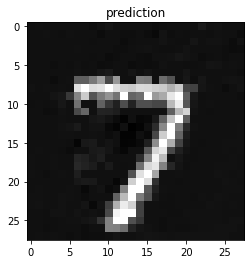

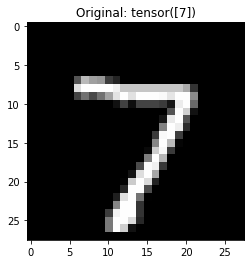

Epoch: 126, Iteration: 0, loss: -0.8677572011947632
Epoch: 126, Iteration: 1000, loss: -0.7007459402084351
Epoch: 126, Iteration: 2000, loss: -0.9133811593055725
Epoch: 126, Iteration: 3000, loss: -0.7266810536384583
Epoch: 127, Iteration: 0, loss: -0.9573919773101807
Epoch: 127, Iteration: 1000, loss: -0.8305402398109436
Epoch: 127, Iteration: 2000, loss: -0.9422819018363953
Epoch: 127, Iteration: 3000, loss: -0.8912563920021057
Epoch: 128, Iteration: 0, loss: -1.0002385377883911
Epoch: 128, Iteration: 1000, loss: -1.0154682397842407
Epoch: 128, Iteration: 2000, loss: -0.857207715511322
Epoch: 128, Iteration: 3000, loss: -0.8925592303276062
Epoch: 129, Iteration: 0, loss: -0.9505985975265503
Epoch: 129, Iteration: 1000, loss: -0.9915432333946228
Epoch: 129, Iteration: 2000, loss: -0.9632409811019897
Epoch: 129, Iteration: 3000, loss: -0.9025643467903137
Epoch: 130, Iteration: 0, loss: -0.8843938708305359
Epoch: 130, Iteration: 1000, loss: -0.8036842942237854
Epoch: 130, Iteration: 200

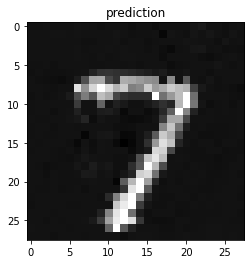

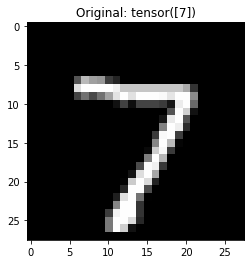

Epoch: 131, Iteration: 0, loss: -0.9535870552062988
Epoch: 131, Iteration: 1000, loss: -0.9148484468460083
Epoch: 131, Iteration: 2000, loss: -0.9095450043678284
Epoch: 131, Iteration: 3000, loss: -0.905213475227356
Epoch: 132, Iteration: 0, loss: -0.33482494950294495
Epoch: 132, Iteration: 1000, loss: -0.8325675129890442
Epoch: 132, Iteration: 2000, loss: -0.8907997608184814
Epoch: 132, Iteration: 3000, loss: -0.7234308123588562
Epoch: 133, Iteration: 0, loss: -0.8703380823135376
Epoch: 133, Iteration: 1000, loss: -0.910957932472229
Epoch: 133, Iteration: 2000, loss: -0.9014557600021362
Epoch: 133, Iteration: 3000, loss: -0.9104790091514587
Epoch: 134, Iteration: 0, loss: -0.9236093163490295
Epoch: 134, Iteration: 1000, loss: -0.7517746686935425
Epoch: 134, Iteration: 2000, loss: -0.1779310554265976
Epoch: 134, Iteration: 3000, loss: -0.9162712693214417
Epoch: 135, Iteration: 0, loss: -0.8714489340782166
Epoch: 135, Iteration: 1000, loss: -0.8900827169418335
Epoch: 135, Iteration: 200

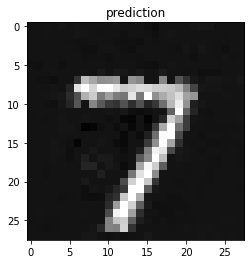

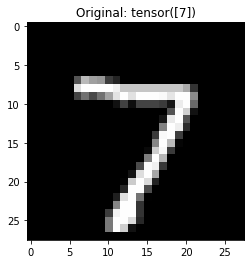

Epoch: 136, Iteration: 0, loss: -0.5677484273910522
Epoch: 136, Iteration: 1000, loss: -0.7879886627197266
Epoch: 136, Iteration: 2000, loss: -0.9039504528045654
Epoch: 136, Iteration: 3000, loss: -0.8789336681365967
Epoch: 137, Iteration: 0, loss: -0.8948436975479126
Epoch: 137, Iteration: 1000, loss: -0.862449049949646
Epoch: 137, Iteration: 2000, loss: -0.8762389421463013
Epoch: 137, Iteration: 3000, loss: -0.9283078908920288
Epoch: 138, Iteration: 0, loss: -0.8798906803131104
Epoch: 138, Iteration: 1000, loss: -0.9856688380241394
Epoch: 138, Iteration: 2000, loss: -0.021249165758490562
Epoch: 138, Iteration: 3000, loss: -0.8696454763412476
Epoch: 139, Iteration: 0, loss: -0.9156578183174133
Epoch: 139, Iteration: 1000, loss: -0.8522846698760986
Epoch: 139, Iteration: 2000, loss: -0.9398629069328308
Epoch: 139, Iteration: 3000, loss: -0.9441626667976379
Epoch: 140, Iteration: 0, loss: 0.11119391024112701
Epoch: 140, Iteration: 1000, loss: -0.9153474569320679
Epoch: 140, Iteration: 2

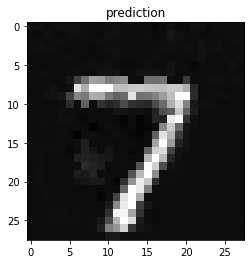

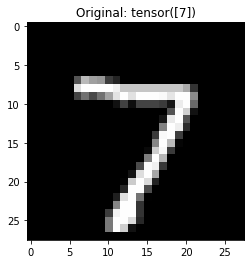

Epoch: 141, Iteration: 0, loss: -0.9632449746131897
Epoch: 141, Iteration: 1000, loss: -0.7000031471252441
Epoch: 141, Iteration: 2000, loss: -0.890151858329773
Epoch: 141, Iteration: 3000, loss: -0.8159934282302856
Epoch: 142, Iteration: 0, loss: -0.8872663974761963
Epoch: 142, Iteration: 1000, loss: -0.9811722636222839
Epoch: 142, Iteration: 2000, loss: -0.9350088834762573
Epoch: 142, Iteration: 3000, loss: -0.8366863131523132
Epoch: 143, Iteration: 0, loss: -0.3620999753475189
Epoch: 143, Iteration: 1000, loss: -0.6407277584075928
Epoch: 143, Iteration: 2000, loss: -0.9028621315956116
Epoch: 143, Iteration: 3000, loss: -0.8690559267997742
Epoch: 144, Iteration: 0, loss: -0.890152633190155
Epoch: 144, Iteration: 1000, loss: -0.9036546945571899
Epoch: 144, Iteration: 2000, loss: -0.8581315279006958
Epoch: 144, Iteration: 3000, loss: -0.9142535924911499
Epoch: 145, Iteration: 0, loss: -0.9692147970199585
Epoch: 145, Iteration: 1000, loss: -0.9684497117996216
Epoch: 145, Iteration: 2000

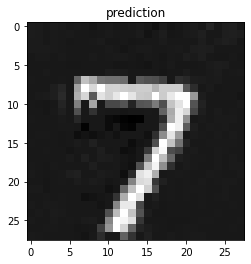

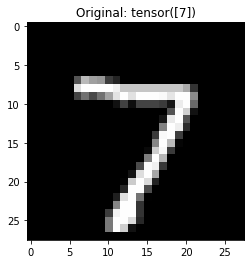

Epoch: 146, Iteration: 0, loss: -0.9570428729057312
Epoch: 146, Iteration: 1000, loss: -0.9214285612106323
Epoch: 146, Iteration: 2000, loss: -0.9778831601142883
Epoch: 146, Iteration: 3000, loss: -0.9423750042915344
Epoch: 147, Iteration: 0, loss: -0.9379183650016785
Epoch: 147, Iteration: 1000, loss: -0.9615604281425476
Epoch: 147, Iteration: 2000, loss: -0.9549970030784607
Epoch: 147, Iteration: 3000, loss: -0.9052844047546387
Epoch: 148, Iteration: 0, loss: -0.8068268299102783
Epoch: 148, Iteration: 1000, loss: -0.9718320369720459
Epoch: 148, Iteration: 2000, loss: -0.9416017532348633
Epoch: 148, Iteration: 3000, loss: -0.9048960208892822
Epoch: 149, Iteration: 0, loss: -0.9955254793167114
Epoch: 149, Iteration: 1000, loss: -0.9569504857063293
Epoch: 149, Iteration: 2000, loss: -0.9606723785400391
Epoch: 149, Iteration: 3000, loss: -0.6667581796646118
Epoch: 150, Iteration: 0, loss: -0.8969377875328064
Epoch: 150, Iteration: 1000, loss: -0.883579671382904
Epoch: 150, Iteration: 200

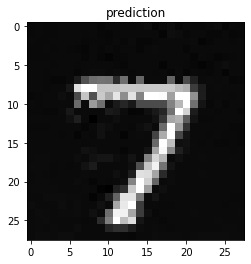

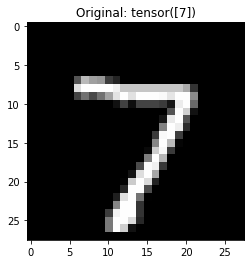

Epoch: 151, Iteration: 0, loss: -0.8556662797927856
Epoch: 151, Iteration: 1000, loss: -0.9251181483268738
Epoch: 151, Iteration: 2000, loss: -0.9227201342582703
Epoch: 151, Iteration: 3000, loss: -0.9574951529502869
Epoch: 152, Iteration: 0, loss: -0.9458497762680054
Epoch: 152, Iteration: 1000, loss: -0.8274251222610474
Epoch: 152, Iteration: 2000, loss: -0.974302351474762
Epoch: 152, Iteration: 3000, loss: -0.9475991725921631
Epoch: 153, Iteration: 0, loss: -0.709168553352356
Epoch: 153, Iteration: 1000, loss: -0.8701809644699097
Epoch: 153, Iteration: 2000, loss: -0.8986565470695496
Epoch: 153, Iteration: 3000, loss: -0.9335991144180298
Epoch: 154, Iteration: 0, loss: -0.9312415719032288
Epoch: 154, Iteration: 1000, loss: -0.9523004293441772
Epoch: 154, Iteration: 2000, loss: -1.041155219078064
Epoch: 154, Iteration: 3000, loss: -0.8742237091064453
Epoch: 155, Iteration: 0, loss: -0.9474645256996155
Epoch: 155, Iteration: 1000, loss: -0.8626219034194946
Epoch: 155, Iteration: 2000,

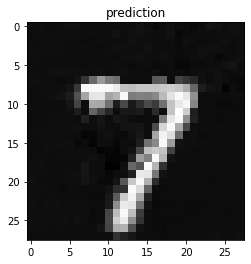

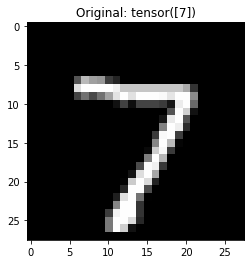

Epoch: 156, Iteration: 0, loss: -0.8459614515304565
Epoch: 156, Iteration: 1000, loss: -0.9437819719314575
Epoch: 156, Iteration: 2000, loss: -0.9159619808197021
Epoch: 156, Iteration: 3000, loss: -0.9458203315734863
Epoch: 157, Iteration: 0, loss: -0.8751646876335144
Epoch: 157, Iteration: 1000, loss: -0.8790491223335266
Epoch: 157, Iteration: 2000, loss: -0.9137270450592041
Epoch: 157, Iteration: 3000, loss: -0.3193368911743164
Epoch: 158, Iteration: 0, loss: -0.954965353012085
Epoch: 158, Iteration: 1000, loss: -0.9430322647094727
Epoch: 158, Iteration: 2000, loss: -0.8794412612915039
Epoch: 158, Iteration: 3000, loss: -0.6845319271087646
Epoch: 159, Iteration: 0, loss: -0.9084798097610474
Epoch: 159, Iteration: 1000, loss: -0.9859181046485901
Epoch: 159, Iteration: 2000, loss: -0.8153300285339355
Epoch: 159, Iteration: 3000, loss: -0.900494396686554
Epoch: 160, Iteration: 0, loss: -0.8761311769485474
Epoch: 160, Iteration: 1000, loss: -0.9055416584014893
Epoch: 160, Iteration: 2000

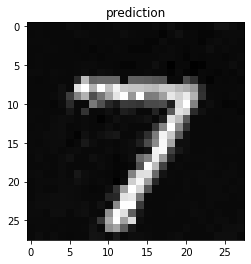

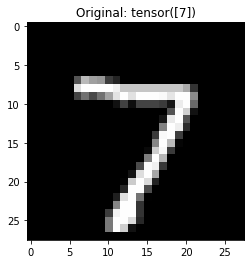

Epoch: 161, Iteration: 0, loss: -0.9268917441368103
Epoch: 161, Iteration: 1000, loss: -0.9538359642028809
Epoch: 161, Iteration: 2000, loss: -0.9738680720329285
Epoch: 161, Iteration: 3000, loss: -0.9836965799331665
Epoch: 162, Iteration: 0, loss: -0.7309780716896057
Epoch: 162, Iteration: 1000, loss: -0.9178897738456726
Epoch: 162, Iteration: 2000, loss: -0.9456323981285095
Epoch: 162, Iteration: 3000, loss: -0.9040921926498413
Epoch: 163, Iteration: 0, loss: -0.9171660542488098
Epoch: 163, Iteration: 1000, loss: -0.9234898686408997
Epoch: 163, Iteration: 2000, loss: -0.9376736879348755
Epoch: 163, Iteration: 3000, loss: -0.962437093257904
Epoch: 164, Iteration: 0, loss: -0.9324556589126587
Epoch: 164, Iteration: 1000, loss: -0.9815877079963684
Epoch: 164, Iteration: 2000, loss: -0.8918488025665283
Epoch: 164, Iteration: 3000, loss: -1.012149453163147
Epoch: 165, Iteration: 0, loss: -0.9002172350883484
Epoch: 165, Iteration: 1000, loss: -0.9305286407470703
Epoch: 165, Iteration: 2000

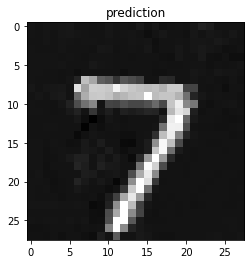

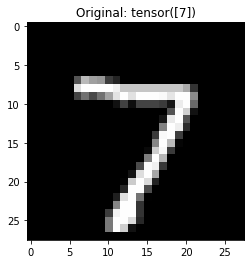

Epoch: 166, Iteration: 0, loss: -0.9103491306304932
Epoch: 166, Iteration: 1000, loss: -0.8028546571731567
Epoch: 166, Iteration: 2000, loss: -0.8872818350791931
Epoch: 166, Iteration: 3000, loss: -0.9282394647598267
Epoch: 167, Iteration: 0, loss: -0.8694419860839844
Epoch: 167, Iteration: 1000, loss: -0.811424970626831
Epoch: 167, Iteration: 2000, loss: -0.9381877183914185
Epoch: 167, Iteration: 3000, loss: 0.6066246032714844
Epoch: 168, Iteration: 0, loss: -0.9518124461174011
Epoch: 168, Iteration: 1000, loss: -0.8682525753974915
Epoch: 168, Iteration: 2000, loss: -0.8974889516830444
Epoch: 168, Iteration: 3000, loss: -0.9315223693847656
Epoch: 169, Iteration: 0, loss: -0.8654168248176575
Epoch: 169, Iteration: 1000, loss: -1.0198079347610474
Epoch: 169, Iteration: 2000, loss: -0.9658731818199158
Epoch: 169, Iteration: 3000, loss: -1.004186749458313
Epoch: 170, Iteration: 0, loss: -0.9086140394210815
Epoch: 170, Iteration: 1000, loss: -0.9772515892982483
Epoch: 170, Iteration: 2000,

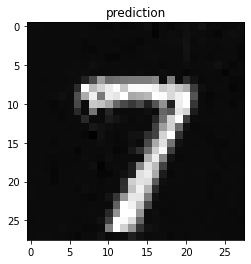

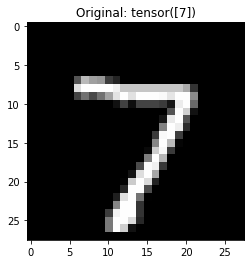

Epoch: 171, Iteration: 0, loss: -0.8943753838539124
Epoch: 171, Iteration: 1000, loss: -0.9451563358306885
Epoch: 171, Iteration: 2000, loss: -0.91456139087677
Epoch: 171, Iteration: 3000, loss: -0.9447081685066223
Epoch: 172, Iteration: 0, loss: -1.0136500597000122
Epoch: 172, Iteration: 1000, loss: -0.9684850573539734
Epoch: 172, Iteration: 2000, loss: -0.926464855670929
Epoch: 172, Iteration: 3000, loss: -0.6035178303718567
Epoch: 173, Iteration: 0, loss: -0.9140318036079407
Epoch: 173, Iteration: 1000, loss: -0.9387054443359375
Epoch: 173, Iteration: 2000, loss: -0.9287540316581726
Epoch: 173, Iteration: 3000, loss: -0.9577640295028687
Epoch: 174, Iteration: 0, loss: -0.9268651604652405
Epoch: 174, Iteration: 1000, loss: -0.9605937004089355
Epoch: 174, Iteration: 2000, loss: -0.8981052041053772
Epoch: 174, Iteration: 3000, loss: -0.9714965224266052
Epoch: 175, Iteration: 0, loss: -0.9256352782249451
Epoch: 175, Iteration: 1000, loss: -0.976536750793457
Epoch: 175, Iteration: 2000, 

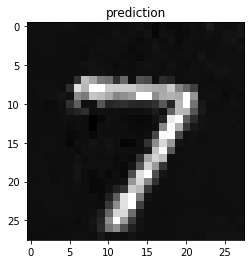

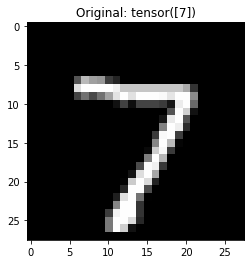

Epoch: 176, Iteration: 0, loss: -0.931504487991333
Epoch: 176, Iteration: 1000, loss: -0.9270517230033875
Epoch: 176, Iteration: 2000, loss: -0.7239541411399841
Epoch: 176, Iteration: 3000, loss: -0.8331604599952698
Epoch: 177, Iteration: 0, loss: -0.9715996980667114
Epoch: 177, Iteration: 1000, loss: -0.9489198327064514
Epoch: 177, Iteration: 2000, loss: -0.9652470946311951
Epoch: 177, Iteration: 3000, loss: -0.9423757195472717
Epoch: 178, Iteration: 0, loss: -0.7809805870056152
Epoch: 178, Iteration: 1000, loss: -0.9553650617599487
Epoch: 178, Iteration: 2000, loss: -0.8304634094238281
Epoch: 178, Iteration: 3000, loss: -0.8556949496269226
Epoch: 179, Iteration: 0, loss: -0.9745654463768005
Epoch: 179, Iteration: 1000, loss: -1.0017043352127075
Epoch: 179, Iteration: 2000, loss: -0.9458595514297485
Epoch: 179, Iteration: 3000, loss: -0.8947479128837585
Epoch: 180, Iteration: 0, loss: -0.8793931603431702
Epoch: 180, Iteration: 1000, loss: -0.9062933325767517
Epoch: 180, Iteration: 200

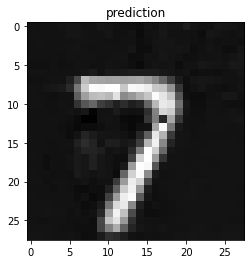

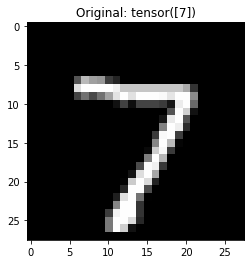

Epoch: 181, Iteration: 0, loss: -0.9252769351005554
Epoch: 181, Iteration: 1000, loss: -0.8419241309165955
Epoch: 181, Iteration: 2000, loss: -0.9016721844673157
Epoch: 181, Iteration: 3000, loss: -0.8683223128318787
Epoch: 182, Iteration: 0, loss: -0.8206081390380859
Epoch: 182, Iteration: 1000, loss: -0.8380983471870422
Epoch: 182, Iteration: 2000, loss: -0.9786569476127625
Epoch: 182, Iteration: 3000, loss: -0.9116092324256897
Epoch: 183, Iteration: 0, loss: -0.580195963382721
Epoch: 183, Iteration: 1000, loss: -0.9678077697753906
Epoch: 183, Iteration: 2000, loss: -0.9498993754386902
Epoch: 183, Iteration: 3000, loss: -0.8876718282699585
Epoch: 184, Iteration: 0, loss: -0.8654463291168213
Epoch: 184, Iteration: 1000, loss: -0.9786232709884644
Epoch: 184, Iteration: 2000, loss: -0.590282678604126
Epoch: 184, Iteration: 3000, loss: -0.7528928518295288
Epoch: 185, Iteration: 0, loss: -0.9787358641624451
Epoch: 185, Iteration: 1000, loss: -0.9787003993988037
Epoch: 185, Iteration: 2000

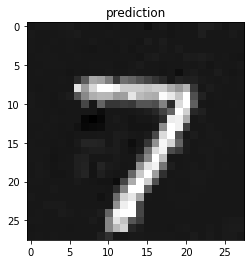

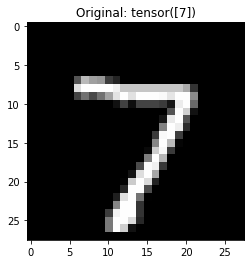

Epoch: 186, Iteration: 0, loss: -1.0052504539489746
Epoch: 186, Iteration: 1000, loss: -0.9583765268325806
Epoch: 186, Iteration: 2000, loss: -0.9846309423446655
Epoch: 186, Iteration: 3000, loss: -1.0046074390411377
Epoch: 187, Iteration: 0, loss: -1.0036574602127075
Epoch: 187, Iteration: 1000, loss: -0.9477260112762451
Epoch: 187, Iteration: 2000, loss: -0.9236432909965515
Epoch: 187, Iteration: 3000, loss: -0.9640263915061951
Epoch: 188, Iteration: 0, loss: -0.8718201518058777
Epoch: 188, Iteration: 1000, loss: -0.9621124863624573
Epoch: 188, Iteration: 2000, loss: -0.8974498510360718
Epoch: 188, Iteration: 3000, loss: -0.9788575172424316
Epoch: 189, Iteration: 0, loss: -1.0062968730926514
Epoch: 189, Iteration: 1000, loss: -0.9525400400161743
Epoch: 189, Iteration: 2000, loss: -0.3744194507598877
Epoch: 189, Iteration: 3000, loss: -0.958070695400238
Epoch: 190, Iteration: 0, loss: -0.5617388486862183
Epoch: 190, Iteration: 1000, loss: -0.9369924664497375
Epoch: 190, Iteration: 200

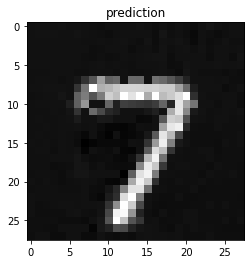

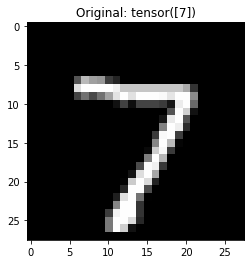

Epoch: 191, Iteration: 0, loss: -0.9795264601707458
Epoch: 191, Iteration: 1000, loss: -0.96871018409729
Epoch: 191, Iteration: 2000, loss: -0.940385103225708
Epoch: 191, Iteration: 3000, loss: -0.8570802211761475
Epoch: 192, Iteration: 0, loss: -0.9648135304450989
Epoch: 192, Iteration: 1000, loss: -0.840067446231842
Epoch: 192, Iteration: 2000, loss: -0.9090672731399536
Epoch: 192, Iteration: 3000, loss: -0.9839465618133545
Epoch: 193, Iteration: 0, loss: -0.9471753835678101
Epoch: 193, Iteration: 1000, loss: -0.8795996308326721
Epoch: 193, Iteration: 2000, loss: -1.0113567113876343
Epoch: 193, Iteration: 3000, loss: -0.9648755192756653
Epoch: 194, Iteration: 0, loss: -0.8911270499229431
Epoch: 194, Iteration: 1000, loss: -0.8524484038352966
Epoch: 194, Iteration: 2000, loss: -0.9237463474273682
Epoch: 194, Iteration: 3000, loss: -0.9087347388267517
Epoch: 195, Iteration: 0, loss: -0.9845010042190552
Epoch: 195, Iteration: 1000, loss: -0.9311270713806152
Epoch: 195, Iteration: 2000, 

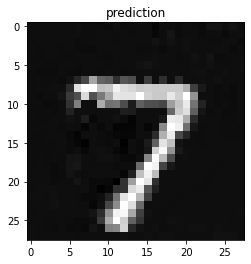

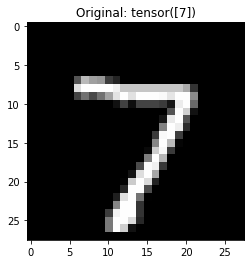

Epoch: 196, Iteration: 0, loss: -0.7529045343399048
Epoch: 196, Iteration: 1000, loss: -1.0001602172851562
Epoch: 196, Iteration: 2000, loss: -0.9080159664154053
Epoch: 196, Iteration: 3000, loss: -0.9220436811447144
Epoch: 197, Iteration: 0, loss: -0.8972610235214233
Epoch: 197, Iteration: 1000, loss: -0.7950249314308167
Epoch: 197, Iteration: 2000, loss: -0.9282425045967102
Epoch: 197, Iteration: 3000, loss: -0.9762735962867737
Epoch: 198, Iteration: 0, loss: -0.9900470972061157
Epoch: 198, Iteration: 1000, loss: -1.009383201599121
Epoch: 198, Iteration: 2000, loss: -0.9466984868049622
Epoch: 198, Iteration: 3000, loss: -0.9757868051528931
Epoch: 199, Iteration: 0, loss: -0.9414713382720947
Epoch: 199, Iteration: 1000, loss: -0.9496554136276245
Epoch: 199, Iteration: 2000, loss: -0.9166637659072876
Epoch: 199, Iteration: 3000, loss: -0.9860641956329346


In [13]:
epochs = 200
save_epoch = 5
mu, sigma, loss = np._fit(epochs, 
                    save_epoch, 
                    train_generator, 
                    test_generator,
                    opt)

In [14]:
loss1, loss2, loss3 = loss

In [15]:
len(loss1), len(loss2), len(loss3)

(40, 750000, 750000)

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
model_save_name = 'np4d2.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(np.state_dict(), path)

In [21]:
import pandas as pd

In [23]:
import numpy

In [29]:
df = pd.DataFrame(loss1)

In [31]:
df.to_csv("/content/gdrive/MyDrive/nll1.csv")

In [34]:
!ls gdrive/MyDrive

'Anschreiben Bot Wohnungsannonce.gdoc'
 Arbeitsproben.gslides
'AWS 3.gslides'
 AWS_HA1.gdoc
'AWS_HA3 (1).gslides'
'AWS HA3.gdoc'
 AWS_HA3.gslides
'BALANCE SHEET TEMPLATE.gsheet'
 Broschüre.gdoc
'Colab Notebooks'
 Customer-Relationship-Manager.gsheet
 DWBI.gdoc
'DWBI L2.gdoc'
'DWBI L3.gdoc'
'DWBI L5.gdoc'
'DWBI L.gdoc'
 Exposé.pdf
 Fallstudie.gslides
'Geschäftliches Jahresbudget (1).gsheet'
'Geschäftliches Jahresbudget.gsheet'
'Geschäftsbericht Lukas.gdoc'
 GKI_HA1_Aufgabe1
 GKI_HA1_b.pdf
 GKI_HA1_Teil2.gsheet
'Ihre zündende Idee .gslides'
 layout1-1.png
'layout l 2.1.pdf'
'layout l 2.2.pdf'
 ML1.gdoc
'Monatsbudget (1).gsheet'
 Monatsbudget.gsheet
 nll1.csv
 np
 np1d.pt
 NP2020.gslides
 np2d2.pt
 np2d.pt
 np3d2.pt
 np4d2.pt
'Planspiel Berechnungen (1).gform'
'Planspiel Berechnungen.gform'
'Planspiel Berechnungen.gsheet'
'Planspiel Berechnungen.ods'
 Quellen.gdoc
'RACI Maßnahmen .gsheet'
'Scoot - Geschäftsentwicklung.gslides'
'Tabellen und Grafiken Geschäftsbericht.gsheet'
 Templ

In [1]:
plt.plot(numpy.array(loss1))

NameError: ignored

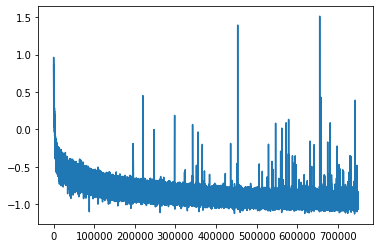

In [35]:
plt.plot(loss2)

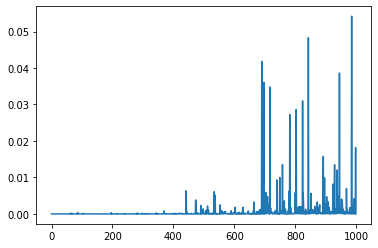

In [20]:
plt.plot(loss3[0:1000])

In [ ]:
test_set = neural_processes.mnist.preprocess_mnist(test_generator, dev, train=False)

In [ ]:
xc, yc, xt, yt = test_set[6]

In [ ]:
m = torch.zeros(28, 28)
x, y = neural_processes.plot.rescale(xt[0], mu.detach()[0], 'cpu')
xk, yk = neural_processes.plot.rescale(xc[0], yc[0], 'cpu')

num_context = xk.shape[0]

for i, val in enumerate(x):
    
    if i < num_context:
      m[val[0], val[1]] = yk[i]
    else:
      m[val[0], val[1]] = y[i]

plt.imshow(m)